# Convolutional Neural Network: fashion mnist data set

Bài viết trên [Machine Learning Cơ bản](https://machinelearningcoban.com/2018/07/06/deeplearning/) giới thiệu về keras bằng bộ số liệu với mô hình Multilayer Perceptron Neural Network (MLP)và đạt được mức độ chính xác là 88.4%. Tác giả bài viết có gợi ý rằng để nâng cao mức độ chính xác chúng ta nên sử dụng Convolutional Neural Networks (CNN) vì MLP bỏ qua thông tin về không gian ảnh (spatial information). 

Theo hướng gợi ý này tôi xây dựng một mô hình CNN đơn giản và đạt được mức độ chính xác 93% như sau: 

In [1]:
# Load bộ dữ liệu: 

from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [2]:
# Chuẩn bị một số thư viện cho hình ảnh hóa số liệu: 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

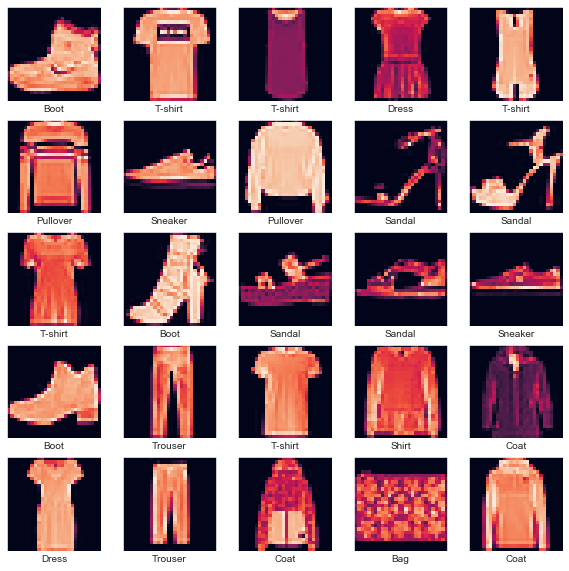

In [3]:
# Một số "quan sát" về bộ dữ liệu: 

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])

In [4]:
# Chuẩn bị dữ liệu: 
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)
train_images, test_images = train_images / 255, test_images  / 255

In [5]:
# Thiết lập Convolutional Neural Networks (CNN): 

import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

W0903 19:33:25.583798 11964 deprecation.py:506] From C:\Users\Zbook\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Huấn luyện CNN trên con máy HP ZBook 15 Workstation có hỗ trợ tính toán bằng GPU với NVIDIA Quadro K1100 M (con Card này giờ hơi lỗi thời chỉ có 384 nhân CUDA, Bus chỉ 128 với 2 Gi RAM) thì thời gian huấn luyện là khoảng 878s: 

In [6]:
# Huấn luyện CNN và tính thời gian huấn luyện: 

import time
start_time = time.time()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=20, verbose=0, validation_split=0.1)

print('Training Time:', time.time() - start_time)

Training Time: 878.4621267318726


In [7]:
# Accuracy trên Train Data: 
print('Train Accuracy:', model.evaluate(test_images, test_labels, verbose=0))

Train Accuracy: [0.24918821364194155, 0.9268]


Khảo sát Accuracy theo epoch chúng ta có thể kì vọng rằng mức độ chính xác trên train data có thể dao động nhưng sẽ quanh ngưỡng từ 92% - 93%:  

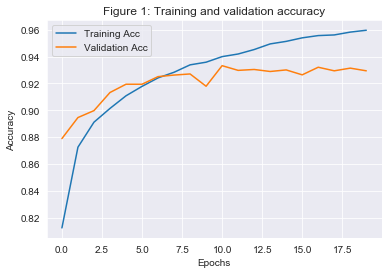

In [8]:
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(acc_values, label='Training Acc')
plt.plot(val_acc_values, label='Validation Acc')
plt.title('Figure 1: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Dừng sớm (Early Stopping)

Để tiết kiệm thời gian huấn luyện chúng ta có thể, ví dụ, dừng huấn luyện CNN nếu như mức độ chính xác trên validation data không được cải thiện sau một số bước nào đó. Giả sử tiêu chí lựa chọn là Accuracy trên Validation data và thuật toán sẽ dừng lại sau 5 bước: 

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_acc', patience = 5)

start_time = time.time()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=20, 
                    verbose=0, validation_split=0.1, callbacks=[early_stop])

print('Training Time with Early Stopping:', time.time() - start_time)

Training Time with Early Stopping: 433.5366690158844


Lúc này thời gian huấn luyện giảm xuống chỉ con 433s nhưng Accuracy trên Test Data thì giảm xuống gần như không đáng kể: 

In [10]:
print('Train Accuracy with Early Stopping:', model.evaluate(test_images, test_labels, verbose=0))

Train Accuracy with Early Stopping: [0.289168933929503, 0.9263]


Chúng ta có thể khảo sát quá trình huấn luyện: 

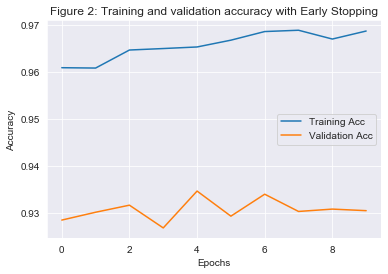

In [12]:
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(acc_values, label='Training Acc')
plt.plot(val_acc_values, label='Validation Acc')
plt.title('Figure 2: Training and validation accuracy with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Thời gian huấn luyện giảm như vậy vì mô hình chỉ dừng ở epoch 10: 

In [13]:
len(acc_values)

10

# Vài kết luận

- Với kết quả ở trên chỉ ra rằng chúng ta có bằng chứng cho thấy CNN hiệu quả hơn so với MLP. 
- Những kĩ thuật tinh chỉnh mô hình cho CNN chưa được đề cập. 
- Các kĩ thuật dừng sớm phức tạp hơn chưa được được đề cập. 

# Tham khảo

1. https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
2. https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
3. https://machinelearningcoban.com/2018/07/06/deeplearning/